# Exercice 6
Résolvez l'équation de la chaleur homogène adimensionnelle :
$$ \frac{\partial u}{\partial t} - \frac{\partial^2u}{\partial x^2} = 0 \quad \forall x \in [0,1] $$
 	
avec des conditions de Dirichelet : $u(t, 0) = 0 = u(t, 1)$ $\forall t$ et une valeur initiale carrée : $u(0, x) = 1_{[0.25, 0.75]}$.

1. Implémentez une résolution spatiale en différences centrées d'ordre 2, et intégrez temporellement en utilisant les trois méthodes d'Euler;
2. Faites varier les paramètres et discutez de la stabilité.

## Solution
On définit la matrice liée aux différences centrées, de taille N+2 pour acceuillir les conditions de bord  (attention, pour une équation stationnaire telle que l'ex. 5 il n'est pas necéssaire de faire cet ajout).
$$
\mathbf{D} = \begin{pmatrix}
   &        &        &        &   \\
 1 & -2     & 1      &        &   \\
   & \ddots & \ddots & \ddots &   \\
   &        & 1      & -2     & 1 \\
   &        &        &        &   \\
\end{pmatrix}
$$

et 
$$ \lambda = \frac{ \Delta t }{ \Delta x^2 } $$

### Euler avant
$$\mathbf{u}^{n+1} = (\mathbf{I}+\lambda\mathbf{D})\mathbf{u}^{n}$$
### Euler arrière
$$\mathbf{u}^{n+1} = (\mathbf{I}-\lambda\mathbf{D})^{-1}\mathbf{u}^{n}$$
### Euler centré
$$\mathbf{u}^{n+1} = \left(\mathbf{I}-\frac{\lambda}{2}\mathbf{D}\right)^{-1}\left(\mathbf{I}+\frac{\lambda}{2}\mathbf{D}\right)\mathbf{u}^{n}$$



In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Définition des fonctions et constantes utiles

# Condition initiale carrée
def u0(x):
    return np.where((x >= 0.25) & (x <= 0.75), 1.0, 0.0)

# Euler explicite
def euler_explicite(x, t_max, dt, u0_vec, D):
    # Initialisation
    dx = x[1] - x[0]
    lmb = dt / dx**2
    
    N_t = int(t_max/dt)+1
    
    t = np.linspace(0, t_max, N_t)
    u = np.zeros((N_t, len(u0_vec)))
    u[0,:] = u0_vec
    
    for n in range(N_t-1):
        u[n+1, :] = (np.eye(len(u0_vec)) + lmb * D) @ u[n, :]
        
    return t, u

# Euler implicite
def euler_implicite(x, t_max, dt, u0_vec, D):
    # Initialisation
    dx = x[1] - x[0]
    lmb = dt / dx**2
    
    N_t = int(t_max/dt)+1
    
    t = np.linspace(0, t_max, N_t)
    u = np.zeros((N_t, len(u0_vec)))
    u[0,:] = u0_vec
    
    A = np.eye(len(u0_vec)) - lmb * D
    A_inv = np.linalg.inv(A)
    
    for n in range(N_t-1):
        u[n+1, :] = A_inv @ u[n, :]
        
    return t, u

# Crank-Nicolson / Euler centré
def crank_nicolson(x, t_max, dt, u0_vec, D):
    # Initialisation
    dx = x[1] - x[0]
    lmb = dt / dx**2
    
    N_t = int(t_max/dt)+1
    
    t = np.linspace(0, t_max, N_t)
    u = np.zeros((N_t, len(u0_vec)))
    u[0,:] = u0_vec
    
    A = np.eye(len(u0_vec)) - lmb/2 * D
    A_inv = np.linalg.inv(A)
    
    AA =  A_inv @ (np.eye(len(u0_vec)) + lmb/2 * D)
    
    for n in range(N_t-1):
        u[n+1, :] = AA @ u[n, :]
        
    return t, u

# Solution analytique 
def u_exact(t_vec, a, b):
    x = np.linspace(0, 1, 1000)
    u = np.zeros((len(t_vec), len(x)))
    for (i, t_) in enumerate(t_vec):
        if t_ == 0:
            u[i,:] = u0(x)
            continue
        for k in range(1, 50):
            kpi = k * np.pi
            ui = 4.0/kpi * np.sin(kpi/4.0) * np.sin(kpi/2.0) * np.exp(-kpi**2 * t_) * np.sin(kpi * x)
            u[i,:] += ui
            
    return x, u

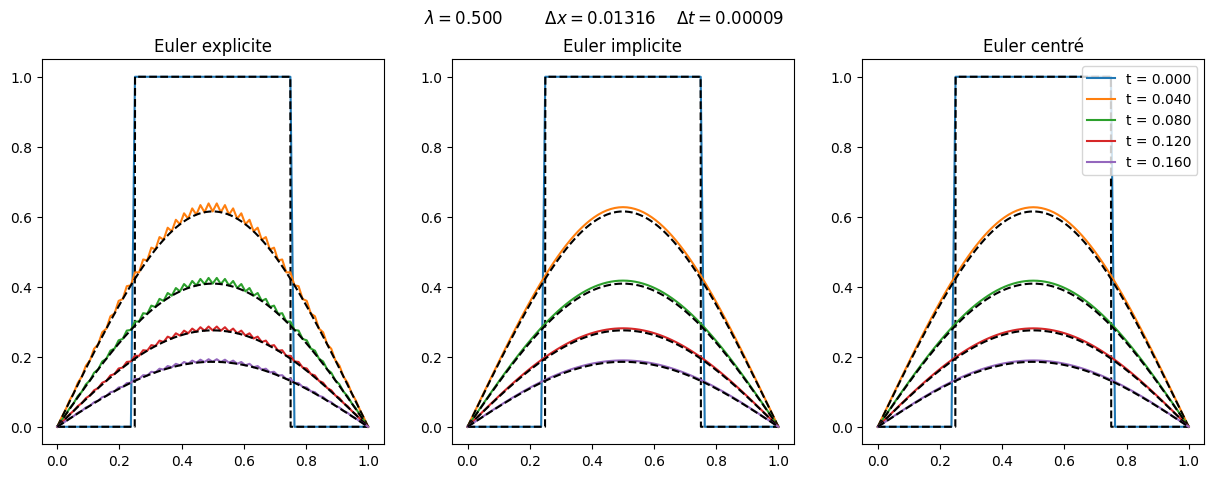

In [2]:
# Solution pour les conditions de Dirichelet
N = 75
lmb = 0.5 # either fix it or compute it from dx and dt
t_max = 0.2

x = np.linspace(0, 1, N+2) # on s'assure que les points de bord sont inclus
dx = x[1] - x[0]

# Condition CFL de stabilité : lmb < 0.5 pour Euler explicite
dt = lmb * dx**2

u0_vec = u0(x)
u0_vec[0] = 0.0
u0_vec[-1] = 0.0

D = np.zeros((N+2, N+2))
for i in range(1, N+1):
    D[i, i-1] = 1.0
    D[i, i] = -2.0
    D[i, i+1] = 1.0

t, u_EE = euler_explicite(x, t_max, dt, u0_vec, D)
_, u_EI = euler_implicite(x, t_max, dt, u0_vec, D)
_, u_CN = crank_nicolson(x, t_max, dt, u0_vec, D)
x_analytique, u_analytique = u_exact(t, 0.25, 0.75)

# Plot the solution at 5 different times, each method in a different subplot
t_idx_plot = range(0, len(t)-1, len(t)//5)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for t_idx in t_idx_plot:
    ax[0].plot(x, u_EE[t_idx,:], label = 't = %.3f' % t[t_idx])
    ax[0].plot(x_analytique, u_analytique[t_idx], 'k--')
    ax[0].set_title('Euler explicite')
    ax[1].plot(x, u_EI[t_idx,:], label = 't = %.3f' % t[t_idx])
    ax[1].plot(x_analytique, u_analytique[t_idx], 'k--')
    ax[1].set_title('Euler implicite')
    ax[2].plot(x, u_CN[t_idx,:], label = 't = %.3f' % t[t_idx])
    ax[2].plot(x_analytique, u_analytique[t_idx], 'k--')
    ax[2].set_title('Euler centré')
    ax[2].legend()

fig.suptitle('$\lambda = %.3f$ \t $\Delta x = %.5f$ \t $\Delta t = %.5f$' % (lmb, dx, dt))
plt.show()

In [3]:
%reset -f

# Exercice 7
Résolvez l'équation de la diffusion radioactive :
$$ \frac{\partial u}{\partial t} - \nu\frac{\partial^2u}{\partial x^2} + bu = 0 \quad \forall x \in [0,1], \quad \nu=0.1,\quad b=1 $$

avec des conditions de Dirichelet : $u(t, 0) = 0 = u(t, 1)$ $\forall t$
et une valeur initiale : $u(0, x) = \sin(\pi x)$.

- Implémentez un schéma implicite $O({\Delta x^2}) + O({\Delta t})$ et résolvez le sous forme matricielle;
- Déterminez les conditions de stabilités et représentez graphiquement l'erreur en $t=1$ pour divers valeurs de paramètres.

## Solution
Comme précédemment, on peut implementer un schéma en différence centrée et Euler explicite afin d'obtenir l'ordre désiré. Evidemment, il s'agit du choix de la facilité et bien d'autres solutions existent.

$$
\begin{align*}
    \frac{\partial u}{\partial t} &= \nu\frac{\partial^2u}{\partial x^2} - bu\\
    \Rightarrow u_i^{n+1} &= (1-b\Delta t)u_i^n + \frac{\nu\Delta t}{\Delta x^2}\left(u^n_{i+1}-2u^n_i+u^n_{i-1}\right)\\
    \Leftrightarrow \mathbf{u}_i^{n+1} &= \left((1-b\Delta t)\mathbf{I} + \lambda\mathbf{D}\right)\mathbf{u}_i^{n}
\end{align*}
$$

avec $\lambda = \frac{\nu\Delta t}{\Delta x^2}$ et $\mathbf D$ la matrice associée aux différences centrée comme définie dans l'exercice précédent.

### Stabilité
On suppose une perturbation de la forme $\epsilon^n_j = \phi^n e^{ikx_j}$ évoluant selon le même schéma numérique que la solution :

$$
\begin{align*}
    \epsilon_j^{n+1} &= (1-b\Delta t)\epsilon_j^n + \lambda\left(\epsilon^n_{j+1}-2\epsilon^n_j+\epsilon^n_{j-1}\right)\\
    \Rightarrow \epsilon_j^{n+1} &= \epsilon^n_j\left[1-b\Delta t-4\lambda\sin^2\left(\frac{k\Delta x}{2}\right)\right]\\
    \Rightarrow \left|\phi\right| &= \left|1-b\Delta t-4\lambda\sin^2\left(\frac{k\Delta x}{2}\right)\right|
\end{align*}
$$

Afin de garder une solution stable, il est necessaire que cette amplitude soit plus petite que 1. En prenant le cas le plus défavorable de longueur d'onde, on trouve la condition CFL suivante :

$$
\begin{align*}
    -1+b\Delta t+4\frac{\nu\Delta t}{\Delta x^2} &<1\\
    \Leftrightarrow\Delta t &< \frac{2\Delta x^2}{b\Delta x^2 + 4\nu} 
\end{align*}
$$

In [4]:
# Pour la solution, on modifie légèrement les codes de l'exercice précédent
import numpy as np
import matplotlib.pyplot as plt

# Définition des fonctions et constantes utiles

# Condition initiale carrée


def u0(x, mode='sin'):
    if mode == 'sin':
        return np.sin(np.pi * x)
    elif mode == 'square':
        return np.where((x >= 0.25) & (x <= 0.75), 1.0, 0.0)

# Euler explicite


def euler_explicite(x, t_max, dt, u0_vec, D_mat, b_scalar, nu):
    # Initialisation
    dx = x[1] - x[0]
    lmb = nu * dt / dx**2

    t = np.arange(0, t_max+dt, dt)
    N_t = len(t)
    
    u = np.zeros((N_t, len(u0_vec)))
    u[0, :] = u0_vec

    for n in range(N_t-1):
        u[n+1, :] = ((1-b_scalar*dt) * np.eye(len(u0_vec)) +
                     lmb * D_mat) @ u[n, :]

    return t, u

# Euler implicite


def euler_implicite(x, t_max, dt, u0_vec, D_mat, b_scalar, nu):
    # Initialisation
    dx = x[1] - x[0]
    lmb = nu * dt / dx**2

    t = np.arange(0, t_max+dt, dt)
    N_t = len(t)
    
    u = np.zeros((N_t, len(u0_vec)))
    u[0, :] = u0_vec

    A = (1.0 + b_scalar*dt) * np.eye(len(u0_vec)) - lmb * D_mat
    A_inv = np.linalg.inv(A)

    for n in range(N_t-1):
        u[n+1, :] = A_inv @ u[n, :]

    return t, u

# Crank-Nicolson / Euler centré


def crank_nicolson(x, t_max, dt, u0_vec, D_mat, b_scalar, nu):
    # Initialisation
    dx = x[1] - x[0]
    lmb = nu * dt / dx**2

    t = np.arange(0, t_max+dt, dt)
    N_t = len(t)
    
    u = np.zeros((N_t, len(u0_vec)))
    u[0, :] = u0_vec

    A = (1.0 + b_scalar*dt/2.0) * np.eye(len(u0_vec)) - lmb/2.0 * D_mat
    A_inv = np.linalg.inv(A)

    AA = A_inv @ ((1.0-b_scalar*dt/2.0) * np.eye(len(u0_vec)) + lmb/2.0 * D_mat)

    for n in range(N_t-1):
        u[n+1, :] = AA @ u[n, :]

    return t, u

# Solution analytique


def u_exact(t_vec, b_scalar, nu, mode='sin'):
    x = np.linspace(0, 1, 1000)
    u = np.zeros((len(t_vec), len(x)))

    gamma = b_scalar + np.pi**2 * nu

    if mode == 'sin':
        for (i, t_) in enumerate(t_vec):
            u[i, :] = np.exp(-gamma * t_) * np.sin(np.pi * x)

        return x, u
    elif mode == 'square':
        for (i, t_) in enumerate(t_vec):
            if t_ == 0:
                u[i, :] = u0(x, mode='square')
                continue
            for k in range(1, 50):
                kpi = k * np.pi
                gamma_k = b_scalar + nu * kpi**2
                ui = 4.0/kpi * np.sin(kpi/4.0) * np.sin(kpi/2.0) * \
                    np.exp(-gamma_k * t_) * np.sin(kpi * x)
                u[i, :] += ui
        return x, u

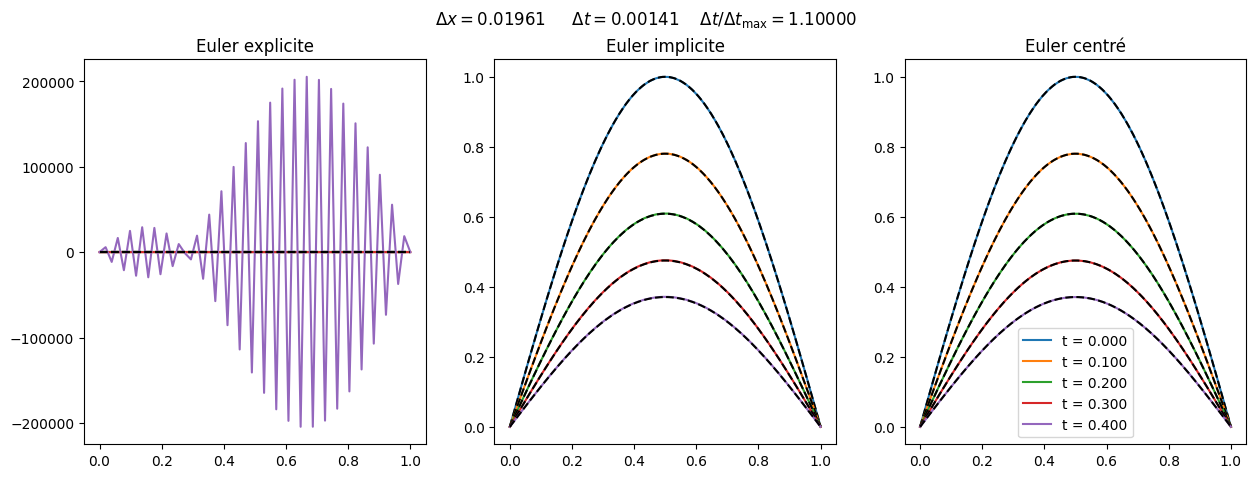

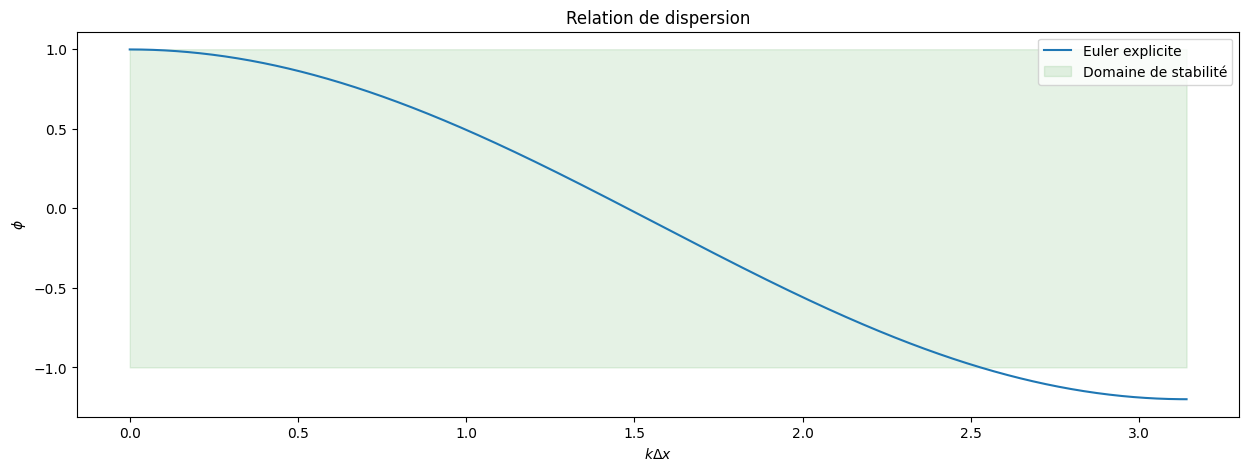

In [5]:
# Solution pour les conditions de Dirichelet
N = 50
nu = 0.15
b_scalar = 1.0
t_max = 0.5

mode = 'sin' # 'sin' or 'square'

x = np.linspace(0, 1, N+2) # on s'assure que les points de bord sont inclus
dx = x[1] - x[0]

# Condition CFL de stabilité : lmb < 0.5 pour Euler explicite
dt_max = 2.0 * dx**2 / (b_scalar * dx**2 + 4*nu)
dt = 1.1 * dt_max

u0_vec = u0(x, mode=mode)

D = np.zeros((N+2, N+2))
for i in range(1, N+1):
    D[i, i-1] = 1.0
    D[i, i] = -2.0
    D[i, i+1] = 1.0

t, u_EE = euler_explicite(x, t_max, dt, u0_vec,  D, b_scalar, nu)
_, u_EI = euler_implicite(x, t_max, dt, u0_vec, D, b_scalar, nu)
_, u_CN = crank_nicolson(x, t_max, dt, u0_vec, D, b_scalar, nu)
x_analytique, u_analytique = u_exact(t, b_scalar, nu, mode=mode)

# Plot the solution at 5 different times, each method in a different subplot
t_idx_plot = range(0, len(t)-1, len(t)//5)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for t_idx in t_idx_plot:
    ax[0].plot(x, u_EE[t_idx,:], label = 't = %.3f' % t[t_idx])
    ax[0].plot(x_analytique, u_analytique[t_idx], 'k--')
    ax[0].set_title('Euler explicite')
    ax[1].plot(x, u_EI[t_idx,:], label = 't = %.3f' % t[t_idx])
    ax[1].plot(x_analytique, u_analytique[t_idx], 'k--')
    ax[1].set_title('Euler implicite')
    ax[2].plot(x, u_CN[t_idx,:], label = 't = %.3f' % t[t_idx])
    ax[2].plot(x_analytique, u_analytique[t_idx], 'k--')
    ax[2].set_title('Euler centré')
    ax[2].legend()

fig.suptitle('$\Delta x = %.5f$ \t $\Delta t = %.5f$ \t ${\Delta t}/{\Delta t_\mathrm{max}} = %.5f$' % (dx, dt, dt/dt_max))
plt.show()

# Plot la relation de dispersion pour Euler explicite
# 1-b\Delta t-4\lambda\sin^2\left(\frac{k\Delta x}{2}\right) pour k\Delta x \in [0, pi]
kdx = np.linspace(0, np.pi, 1000)
lmb = nu * dt / dx**2
relation_dispersion_explicit = 1 - b_scalar * dt - 4 * lmb * np.sin(kdx/2)**2

fig_dispersion, ax_dispersion = plt.subplots(figsize=(15, 5))

ax_dispersion.plot(kdx, relation_dispersion_explicit, label='Euler explicite')
# Color the area where the scheme is stable (-1 < y < 1) in green
ax_dispersion.fill_between(kdx, -1, 1, color='green', alpha=0.1, label='Domaine de stabilité')
ax_dispersion.set_xlabel('$k\Delta x$')
ax_dispersion.set_ylabel('$\phi$')
ax_dispersion.set_title('Relation de dispersion')
ax_dispersion.legend()

plt.show()

# Pourquoi si dx est grand, la solution semble stable même au delà de la condition de stabilité?
# TODO : ajouter les relations de dispersion pour les autres schémas


Le nombre d’onde représentable sur une grille $x$ est donné par $k_\mathrm{max} = \frac{\pi}{\Delta x}$. Le facteur d’amplification pource nombre d’onde est alors $\left|\phi(k_\mathrm{max})\right| = -1+b\Delta t+4\frac{\nu\Delta t}{\Delta x^2}$. Ce facteur d’amplification est le plus grand pour les grands nombres d’onde. C’est donc ces nombres d’onde qui vont se déstabiliser le plus.

In [6]:
%reset -f